<h1><center>Problem Introduction</center></h1>

* Sentiment Analysis is an active research area in the NLP community. A survey of the classic approaches can be found [here](http://www.cs.cornell.edu/home/llee/opinion-mining-sentiment-analysis-survey.html)
*  The problem is defined as a classification task, and the most common approaches are based on bag-of-words.
* There are many papers in the NLP literature, each one describing complex solutions but an interesting [paper](http://www.aclweb.org/anthology/P12-2018) has shown that a  simple bigram approach is quite powerful for the sentiment analysis task. In particular, the authors have used a bigrams with NB log-count ratios as feature and an SVM classifier.

* Introductory materials on this topic can also be found [here](https://web.stanford.edu/~jurafsky/NLPCourseraSlides.html)

<h2><center>Problem Formulation</h2></center>
* There are different tasks associated with the sentiment analysis. In our case, we are considering the problem to associate an attitude to each document, which means looking for a positive or negative dispositions towards entities.  
* Due to the lack of labels for our data, I will use a transfer learning approach.
* The main idea is to use an external corpus of positive and negative words to learn how the syntactic structure is affecting the expression of the sentiment.
* The model will be learned using a data-set annotated with a positive and negative sentiment.
* The learned model can be transferred to our corpus because it does not relay on the occurrences of unigrams or bi-grams but only on the syntactic structure of the positive and negative expressions.

* These are the libraries that I have used in this notebook

In [93]:
from frameworks.KaggleWord2VecUtility import KaggleWord2VecUtility
from nltk.tokenize import word_tokenize
import glob
from tqdm import tqdm
import os
import nltk
import numpy as np
from nltk.tokenize import word_tokenize
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import sent_tokenize
from bs4 import BeautifulSoup
import time
import en_core_web_md
import json
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import re

The positive and negative list of words has been downloaded from [here](https://github.com/jeffreybreen/twitter-sentiment-analysis-tutorial-201107/tree/master/data/opinion-lexicon-English).

In [14]:
path_pos = 'data/positive.txt'
path_neg = 'data/negative.txt'
pos_list = [item.strip().lower() for item in open(path_pos).readlines() if list(item)[0] != ';']
neg_list = [item.strip().lower() for item in open(path_neg).readlines() if list(item)[0] != ';']

* Before learning any models is important to check if in our data there are occurrences of the above positive and negative words.
* I suppose that all the documents are stored in folder named data. Each file is a document, where each line is a sentence

In [15]:
path_in = 'data/'
l = glob.glob(path_in + 'doc_*_sentences.txt')
print('Number of documents :',len(l))
list_polarity_stats = []
for file in tqdm(l):
    sentence_polarity = 0
    pos_value = 0
    neg_value = 0
    sentences = [item for item in open(path_in + os.path.basename(file), 'r', encoding="utf8")]
    for sentence in sentences:
        words = word_tokenize(sentence)
        pos_words = [word for word in words if word in pos_list]
        neg_words = [word for word in words if word in neg_list]
        if len(pos_words) >0 or len(neg_words)>0:
            pos_value+=len(pos_words)/float(len(pos_words)+len(neg_words))
            neg_value+=len(neg_words)/float(len(pos_words)+len(neg_words))
            sentence_polarity +=1
    sentence_polarity=sentence_polarity/float(len(sentences))
    pos_value = pos_value/float(len(sentences))
    neg_value = neg_value/float(len(sentences))
    list_polarity_stats.append((len(sentence),sentence_polarity,pos_value,neg_value))

documents_with_sentiment = len([polarity for _,polarity,*_ in list_polarity_stats if polarity>0])
print('Fraction of documents with sentiment %0.3f'%(documents_with_sentiment/float(len(list_polarity_stats))))
documents_with_sentiment_pos = len([pos for *_,pos,neg in list_polarity_stats if pos>neg])
print('Fraction of documents with sentiment positive %0.3f'%(documents_with_sentiment_pos/float(len(list_polarity_stats))))
documents_with_sentiment_neg = len([neg for *_,pos,neg in list_polarity_stats if neg>pos])
print('Fraction of documents with sentiment negative %0.3f'%(documents_with_sentiment_neg/float(len(list_polarity_stats))))



Number of documents : 58


100%|██████████████████████████████████████████████████████████████| 58/58 [00:05<00:00, 13.03it/s]


Fraction of documents with sentiment 1.000
Fraction of documents with sentiment positive 0.431
Fraction of documents with sentiment negative 0.517


From the above results, I can see that in our data all the documents have occurrences of both positive and negative words, with a small prominence of negative words.

In the following cells, I plot the distributions of the positive and negative words within the documents.

In [ ]:
%matplotlib inline
documents_with_sentiment =  [polarity for _,polarity,*_ in list_polarity_stats]
documents_with_sentiment_pos = [pos for *_,pos,neg in list_polarity_stats if pos>neg]
documents_with_sentiment_neg = [neg for *_,pos,neg in list_polarity_stats if neg>pos]
plt.figure();
plt.title('Fraction of Documents in the corpus with positive and negative words (BoxPlot).');
plt.boxplot(documents_with_sentiment, 0, 'gD');
plt.xticks([1], ['Documents']);
plt.figure();
plt.title('Fraction of Documents in the corpus with positive words (left) and negative words (rigth) (BoxPlot).');
plt.boxplot([documents_with_sentiment_pos,documents_with_sentiment_neg], 0, 'gD');
plt.xticks([1, 2], ['Documents with positive words', 'Documents with negative words']);

* The above visualization shows that all the documents have an expression of attitudes (positive or negative) by just counting the number of positive or negative words within the document.
* In the case of negative words, there are documents where they occur more often. 

* In order to learn a model for our sentiment analysis, I have used the annotated dataset posted [here](http://ai.stanford.edu/~amaas/data/sentiment/), you should download it and store in the data folder following the path in the code.
* This is a data-set of highly polar movie reviews.
* In the following cell, I have processed the data by extracting the sentences for each document and  by removing the HTML tags from the text.
* For the processing step, I have used also some Python classes posted [here](https://github.com/wendykan/DeepLearningMovies)

In [17]:
def extract_sentences(review):
    #remove html
    review_text = BeautifulSoup(review,'html5lib').get_text()
    return sent_tokenize(review_text)

# this will be a dictionary that contains all the data of the aclImdb data-set.
data_review ={}
kaggleWord2VecUtility = KaggleWord2VecUtility()
# Load the punkt tokenizer
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

path_in= 'data/aclImdb/train/pos/'
l = glob.glob(path_in + '*.txt')
print('Number of documents in %s :'%path_in, len(l))
list_words = []
list_sentences =[]
for file in tqdm(l):
        content = open(path_in + os.path.basename(file), 'r', encoding="utf8").read()
        words = kaggleWord2VecUtility.review_to_wordlist(content,True)
        list_words.append(words)
        list_sentences.append(extract_sentences(content))
data_review['train_pos']={'label':1,'list_words':list_words,'list_sentences':list_sentences}

path_in= 'data/aclImdb/train/neg/'
l = glob.glob(path_in + '*.txt')
print('Number of documents in %s :'%path_in, len(l))
list_words = []
list_sentences =[]
for file in tqdm(l):
        content = open(path_in + os.path.basename(file), 'r', encoding="utf8").read()
        words = kaggleWord2VecUtility.review_to_wordlist(content,True)
        list_words.append(words)
        list_sentences.append(extract_sentences(content))
data_review['train_neg']={'label':-1,'list_words':list_words,'list_sentences':list_sentences}


path_in= 'data/aclImdb/test/pos/'
l = glob.glob(path_in + '*.txt')
print('Number of documents in %s :'%path_in, len(l))
list_words = []
list_sentences =[]
for file in tqdm(l):
        content = open(path_in + os.path.basename(file), 'r', encoding="utf8").read()
        words = kaggleWord2VecUtility.review_to_wordlist(content,True)
        list_words.append(words)
        list_sentences.append(extract_sentences(content))
data_review['test_pos']={'label':1,'list_words':list_words,'list_sentences':extract_sentences(content)}


path_in= 'data/aclImdb/test/neg/'
l = glob.glob(path_in + '*.txt')
print('Number of documents in %s :'%path_in, len(l))
list_words = []
list_sentences =[]
for file in tqdm(l):
        content = open(path_in + os.path.basename(file), 'r', encoding="utf8").read()
        words = kaggleWord2VecUtility.review_to_wordlist(content,True)
        list_words.append(words)
        list_sentences.append(extract_sentences(content))
data_review['test_neg']={'label':-1,'list_words':list_words,'list_sentences':list_sentences}


Number of documents in sentimentdata/aclImdb/train/pos/ : 12500


100%|███████████████████████████████████████████████████████| 12500/12500 [01:31<00:00, 151.58it/s]


Number of documents in sentimentdata/aclImdb/train/neg/ : 12500


100%|███████████████████████████████████████████████████████| 12500/12500 [01:33<00:00, 134.22it/s]


Number of documents in sentimentdata/aclImdb/test/pos/ : 12500


100%|███████████████████████████████████████████████████████| 12500/12500 [01:32<00:00, 134.42it/s]


Number of documents in sentimentdata/aclImdb/test/neg/ : 12500


100%|███████████████████████████████████████████████████████| 12500/12500 [01:34<00:00, 131.96it/s]


* I will check what will be the accuracy if I classify each document as positive (negative) by just checking if the number of its positive (negative) words is greater than negative (positive) ones. 
* I will consider as positive (negative) the words if it is in the list of positive (negative) words loaded before.

In [18]:
def intersect(a, _set):
    return list(set(a) & _set)

pos_set = set(pos_list)
neg_set = set(neg_list)
correct_labels = 0
error_labels = 0
not_classified = 0
doc_total =0
for key in data_review:
    review = data_review[key]
    label = review ['label']
    list_docs =review['list_words']
    label_docs = []
    doc_total+=len(list_docs)
    for doc in tqdm(list_docs):
        pos_values = intersect(doc, pos_set)
        neg_values = intersect(doc, neg_set)
        if len(pos_values)>len(neg_values):
            label_docs.append(1)
        elif len(pos_values)<len(neg_values):
            label_docs.append(-1)
        else:
            label_docs.append(0)
    counting = Counter(label_docs)
    for key_label in counting:
        if label==0:
            not_classified+=counting[key_label]
        if label==key_label:
            correct_labels+=counting[key_label]
        else:
            error_labels+=counting[key_label]
            
print('Correct labels %0.3f, Error %0.3f Not Classfied %0.3f  '%(correct_labels/float(doc_total),error_labels/float(doc_total),not_classified/float(doc_total)))            
               

100%|█████████████████████████████████████████████████████| 12500/12500 [00:00<00:00, 32214.67it/s]


Correct labels 0.693, Error 0.307 Not Classfied 0.000  


* In this dataset, if we use the approach described before we can achieve an accuracy of ~70%.
* The idea is not just to use the list of positive or negative words but learning the impact of the syntactic structure on the sentiment, in order to transfer that to our data.

I load the entity model that I will use in the next cells.

In [19]:
print('Loading the entity model..')
start_time = time.time()
nlp = en_core_web_md.load()
elapsed_time = time.time() - start_time
print('Model loaded in %f seconds'%(elapsed_time))
entities = ['PERSON','ORG','GPE','LOC']

Loading the entity model..
Model loaded in 11.295646 seconds


In the next cells, I define a set of function that I have used for extract the syntactic structure features.

In [20]:
def extract_entities(spacy_sentence,value_entities=entities):
    return [ent.lemma_ for ent in spacy_sentence.ents if ent.label_ in value_entities ]

def extract_noun(spacy_sentence):
    return [ word.lemma_ for word in spacy_sentence if word.pos_ in ['NOUN','PROPN']]

def extract_verb(spacy_sentence):
    return [ word.lemma_ for word in spacy_sentence if word.pos_ == 'VERB']

def extract_adj(spacy_sentence):
    return [ word.lemma_ for word in spacy_sentence if word.pos_ == 'ADJ']

def extract_adv(spacy_sentence):
    return [ word.lemma_ for word in spacy_sentence if word.pos_ == 'ADV']

# this function extracts an hash map, where each word (key) is associated with a list of words, 
# which is extracted from the parse dependency tree rooted in the key, 
#and by filtering only the words that are localized on the left of the key. 
def extract_close_left(spacy_sentence):
    hash_close_left ={}
    l = [ word for word in spacy_sentence]
    for word in l:
          hash_close_left[word.lemma_]=[w.lemma_ for w in word.lefts]
    return hash_close_left

# this function extracts an hash map, where each word (key) is associated with a list of words, 
# which is extracted from the parse dependency tree rooted in the key, 
#and by filtering only the words that are localized on the rights of the key.        
def extract_close_right(spacy_sentence):
    hash_close_right ={}
    l = [ word for word in spacy_sentence]
    for word in l:
          hash_close_right[word.lemma_]=[w.lemma_ for w in word.rights]
    return hash_close_right

def filter_word(lemma_list,set_word):
    return intersect(lemma_list,set_word)

# from http://textacy.readthedocs.io/en/latest/_modules/textacy/spacy_utils.html
def is_negated_verb(token):
    """
    Returns True if verb is negated by one of its (dependency parse) children,
    False otherwise.

    Args:
        token (``spacy.Token``): parent document must have parse information

    Returns:
        bool

    TODO: generalize to other parts of speech; rule-based is pretty lacking,
    so will probably require training a model; this is an unsolved research problem
    """
    if token.doc.is_parsed is False:
        raise ValueError('token is not parsed')
    if token.pos_ == 'VERB' and any(c.dep_ == 'neg' for c in token.children):
        return True
    # if (token.pos == NOUN
    #         and any(c.dep_ == 'det' and c.lower_ == 'no' for c in token.children)):
    #     return True
    return False

def extract_negative_part(spacy_sentence):
    return [word.lemma_ for word in spacy_sentence if is_negated_verb(word) or word.lemma_ in ['not','no'] ]
    


In the following cell, there are examples of outputs of the above functions.

In [21]:
example_sentence = data_review['test_pos']['list_sentences'][10]
print('Sentence:',example_sentence)
spacy_sentence = nlp(example_sentence)

lemma_list = [ word.lemma_ for word in spacy_sentence]
print('Lemma:',lemma_list)

pos_word = filter_word(lemma_list,pos_set)
print('Pos word:',pos_word)

neg_word = filter_word(lemma_list,neg_set)
print('Neg word:',neg_word)

hash_close_right = extract_close_right(spacy_sentence)
print('hash_close_rigth:',json.dumps(hash_close_right, indent=2))

hash_close_left = extract_close_left(spacy_sentence)
print('hash_close_left:',json.dumps(hash_close_left, indent=2))

entity_list = extract_entities(spacy_sentence)
print('Entities:',entity_list)

noun_list = extract_noun(spacy_sentence)
print('Noun list:',noun_list)

verb_list = extract_verb(spacy_sentence)
print('Verb list:',verb_list)

adj_list = extract_adj(spacy_sentence)
print('adj list:',adj_list)

adv_list = extract_adv(spacy_sentence)
print('adv list:',adv_list)

Sentence: The movie has some slow spots and could have used the wasted 15 minutes to strengthen the character relationships.
Lemma: ['the', 'movie', 'have', 'some', 'slow', 'spot', 'and', 'could', 'have', 'use', 'the', 'waste', '15', 'minute', 'to', 'strengthen', 'the', 'character', 'relationship', '.']
Pos word: []
Neg word: ['slow', 'waste']
hash_close_rigth: {
  "the": [],
  "movie": [],
  "have": [],
  "some": [],
  "slow": [],
  "spot": [],
  "and": [],
  "could": [],
  "use": [
    "minute",
    "strengthen",
    "."
  ],
  "waste": [],
  "15": [],
  "minute": [],
  "to": [],
  "strengthen": [
    "relationship"
  ],
  "character": [],
  "relationship": [],
  ".": []
}
hash_close_left: {
  "the": [],
  "movie": [
    "the"
  ],
  "have": [],
  "some": [],
  "slow": [],
  "spot": [
    "some",
    "slow"
  ],
  "and": [],
  "could": [],
  "use": [
    "could",
    "have"
  ],
  "waste": [],
  "15": [],
  "minute": [
    "the",
    "waste",
    "15"
  ],
  "to": [],
  "strengthen":

In the next cell, there is an example of what the extract_negative_part function does.

In [22]:
example_sentence = 'Mr Ken doesn\'t like much happy salad with mango but he prefers bread with no garlics';
print(example_sentence)
spacy_sentence = nlp(example_sentence)
print('Extract negative part',extract_negative_part(spacy_sentence))

Mr Ken doesn't like much happy salad with mango but he prefers bread with no garlics
Extract negative part ['not', 'like', 'no']


* In the next cell, there are all the functions that have been implemented to extract syntactic information from each sentence.
* Each function has the same interface to facilitate the feature extraction code.
* Each function is an indicator method, which returns 1 if a condition is met 0 otherwise.
* Each function has a comment on the top of the signature that describes what condition they are checking.

In [25]:

# 1 if the positive words are greater than the negative words otherwise 0
def feature_indicator_0(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    if len(pos_words)>len(neg_words):
        return 1
    else:
        return 0
    
# 1 if the negative words are greater than the positive words otherwise 0
def feature_indicator_1(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    if len(pos_words)<len(neg_words):
        return 1
    else:
        return 0
    
# 1 if at least one positive word is left closed to a verb otherwise 0
def feature_indicator_2(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        selection = [ item for item in left if item in verb_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is right closed to a verb otherwise 0
def feature_indicator_3(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        selection = [ item for item in rigth if item in verb_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is left closed to a noun otherwise 0
def feature_indicator_4(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        selection = [ item for item in left if item in noun_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is  right closed to a noun otherwise 0
def feature_indicator_5(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        selection = [ item for item in rigth if item in noun_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is left closed to a verb otherwise 0
def feature_indicator_6(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        selection = [ item for item in left if item in verb_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is right closed to a verb otherwise 0
def feature_indicator_7(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        selection = [ item for item in rigth if item in verb_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is left closed to a noun otherwise 0
def feature_indicator_8(lemma_list,pos_words,neg_words,hash_close_rigth,
                        hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        selection = [ item for item in left if item in noun_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is right closed to a noun otherwise 0
def feature_indicator_9(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        selection = [item  for item in rigth if item in noun_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is left closed to an entity otherwise 0
def feature_indicator_10(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        for item in left:
            for entity in entity_list:
                if item in entity.split(' '):
                    return 1
    return 0

# 1 if at least one positive word is right closed to an entity otherwise 0
def feature_indicator_11(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        for item in rigth:
            for entity in entity_list:
                if item in entity.split(' '):
                    return 1
    return 0

# 1 if at least one negative word is left closed to an entity otherwise 0
def feature_indicator_12(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        for item in left:
            for entity in entity_list:
                if item in entity.split(' '):
                    return 1
    return 0

# 1 if at least one negative word is right closed to an entity otherwise 0
def feature_indicator_13(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        for item in rigth:
            for entity in entity_list:
                if item in entity.split(' '):
                    return 1
    return 0


# 1 if at least one positive word is left closed to an adjective otherwise 0
def feature_indicator_14(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        selection = [ item  for item in left if item in adj_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is right closed to an adjective otherwise 0
def feature_indicator_15(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        selection = [ item  for item in rigth if item in adj_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is left closed to an adverb otherwise 0
def feature_indicator_16(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        selection = [ item for item in left if item in adv_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is right closed to an adverb otherwise 0
def feature_indicator_17(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        selection = [ item for item in rigth if item in adv_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is left closed to an adjective otherwise 0
def feature_indicator_18(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        selection = [ item for item in left if item in adj_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is right closed to an adjective otherwise 0
def feature_indicator_19(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        selection = [item  for item in rigth if item in adj_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative words is left closed to an adverb otherwise 0
def feature_indicator_20(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        selection = [ item for item in left if item in adv_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is right closed to an adverb otherwise 0
def feature_indicator_21(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        selection = [ item for item in rigth if item in adv_words ]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is left closed to a negation part otherwise 0
def feature_indicator_22(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        left = hash_close_left[neg_word]
        selection = [ item for item in left if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is left closed to a negation part otherwise 0
def feature_indicator_23(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        left = hash_close_left[pos_word]
        selection = [ item for item in left if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one negative word is right closed to a negation part otherwise 0
def feature_indicator_24(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for neg_word in neg_words:
        rigth = hash_close_rigth[neg_word]
        selection = [item for item in rigth if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least one positive word is right closed to a negation part otherwise 0
def feature_indicator_25(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for pos_word in pos_words:
        rigth = hash_close_rigth[pos_word]
        selection = [ item for item in rigth if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least adjective is left closed to a negation part otherwise 0
def feature_indicator_26(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for adj_word in adj_words:
        left = hash_close_left[adj_word]
        selection = [ item for item in left if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least adjective is right closed to a negation part otherwise 0
def feature_indicator_27(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for adj_word in adj_words:
        rigth = hash_close_rigth[adj_word]
        selection = [ item for item in rigth if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least adverb is left closed to a negation part otherwise 0
def feature_indicator_28(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for adv_word in adv_words:
        left = hash_close_left[adv_word]
        selection = [ item for item in left if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# 1 if at least adverb is right closed to a negation part otherwise 0
def feature_indicator_29(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list):
    for adv_word in adv_words:
        rigth = hash_close_rigth[adv_word]
        selection = [ item for item in rigth if item in neg_list]
        if len(selection)>0:
            return 1
    return 0

# this data structure is used to make the call back to the above functions easier.
function_caller ={}
function_caller[0]=feature_indicator_0
function_caller[1]=feature_indicator_1
function_caller[2]=feature_indicator_2
function_caller[3]=feature_indicator_3
function_caller[4]=feature_indicator_4
function_caller[5]=feature_indicator_5
function_caller[6]=feature_indicator_6
function_caller[7]=feature_indicator_7
function_caller[8]=feature_indicator_8
function_caller[9]=feature_indicator_9
function_caller[10]=feature_indicator_10
function_caller[11]=feature_indicator_11
function_caller[12]=feature_indicator_12
function_caller[13]=feature_indicator_13
function_caller[14]=feature_indicator_14
function_caller[15]=feature_indicator_15
function_caller[16]=feature_indicator_16
function_caller[17]=feature_indicator_17
function_caller[18]=feature_indicator_18
function_caller[19]=feature_indicator_19
function_caller[20]=feature_indicator_20
function_caller[21]=feature_indicator_21
function_caller[22]=feature_indicator_22
function_caller[23]=feature_indicator_23
function_caller[24]=feature_indicator_24
function_caller[25]=feature_indicator_25
function_caller[26]=feature_indicator_26
function_caller[27]=feature_indicator_27
function_caller[28]=feature_indicator_28
function_caller[29]=feature_indicator_29

# this function is used to extract all the above features
def main_function(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list,
                  function_caller):
    list_output = []
    for key in function_caller:
        value = function_caller[key](lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list)
        list_output.append(value)
    return list_output
        


* Before learning any models, I will check if all the features are good enough to indicate if the sentence is positive or negative.
* I will run a simple feature selection approach looking at how many times the features are triggered in the positive or negative cases.
* In the next cell, I extract the feature for each sentence in the annotated data-set and I have assigned to the sentence a positive (negative) label if its document is labeled as positive (negative).

In [27]:
feature_sentences = []
label_sentences = []
start_time = time.time()
for key in data_review:
    review = data_review[key]
    label = review ['label']
    list_sentences =review['list_sentences']
    for doc_sentences in tqdm(list_sentences):
        for sentence in doc_sentences:
            spacy_sentence = nlp(sentence)
            lemma_list = [ word.lemma_ for word in spacy_sentence]
            pos_words = filter_word(lemma_list,pos_set)
            neg_words = filter_word(lemma_list,neg_set)
            hash_close_rigth = extract_close_right(spacy_sentence)
            hash_close_left = extract_close_left(spacy_sentence)
            entity_list = extract_entities(spacy_sentence)
            noun_words = extract_noun(spacy_sentence)
            verb_words = extract_verb(spacy_sentence)
            adj_words = extract_adj(spacy_sentence)
            adv_words = extract_adv(spacy_sentence)
            list_value_feature = main_function(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list,function_caller)
            if sum(list_value_feature)!=0:
                label_sentences.append(label)
                feature_sentences.append(list_value_feature)
elapsed_time = time.time() - start_time
print('Features extracted in %f seconds'%(elapsed_time))
assert len(feature_sentences)==len(label_sentences), 'feature size needs to be equal to label_size'
                

100%|████████████████████████████████████████████████████████| 12500/12500 [06:10<00:00, 24.73it/s]


Features extracted in 1141.172271 seconds


I print how many times the features are activated and how many samples I have for each class.

In [28]:
matrix_feature = np.vstack(feature_sentences)
print('Dimension matrix feature:',matrix_feature.shape)
print('Dimension labels:',len(label_sentences))
label_counter = Counter(label_sentences)
print ('Labels counter:',label_counter)
print('Features Activations:')
print(np.sum(matrix_feature,axis=0))


Dimension matrix feature: (304868, 30)
Dimension labels: 304868
Labels counter: Counter({-1: 204274, 1: 100594})
Features Activations:
[125626 143042  16555  28865  23562  38397  25320  37981  41019  35035
   5642   5530   9092   2968  28617  10845  50413   7110  42556  14914
  59372   8904  13995   4464  14305   6670   6159  11654    512   1194]


The classes don't have the same number of instances. It will be important for understanding the real performance of the method to look at the F-measure, instead of the classical accuracy measure because we have an unbalanced classification problem.

In the next cell, I will check the coherence of the features activation respect to the labels.

In [29]:
indices_negative = [i for i,x in enumerate(label_sentences) if x == -1]
indices_positive = [i for i,x in enumerate(label_sentences) if x == 1]
matrix_positive = matrix_feature[indices_positive,:]
matrix_negative = matrix_feature[indices_negative,:]
activation_positive = np.sum(matrix_positive,axis=0)/matrix_positive.shape[0]
activation_negative = np.sum(matrix_negative,axis=0)/matrix_negative.shape[0]
diff_activation = activation_positive-activation_negative.tolist()
description_features =[' 1 if the positive words are greater than the negative words otherwise 0',
'negative words are greater than the positive words',
'at least one positive word is left closed to a verb',
'at least one positive word is right closed to a verb',
'at least one positive word is left closed to a noun',
'at least one positive word is  right closed to a noun',
'at least one negative word is left closed to a verb',
'at least one negative word is right closed to a verb',
'at least one negative word is left closed to a noun',
'at least one negative word is right closed to a noun',
'at least one positive word is left closed to an entity',
'at least one positive word is right closed to an entity',
'at least one negative word is left closed to an entity',
'at least one negative word is right closed to an entity',
'at least one positive word is left closed to an adjective',
'at least one positive word is right closed to an adjective',
'at least one positive word is left closed to an adverb',
'at least one positive word is right closed to an adverb',
'at least one negative word is left closed to an adjective',
'at least one negative word is right closed to an adjective',
'at least one negative words is left closed to an adverb',
'at least one negative word is right closed to an adverb',
'at least one negative word is left closed to a negation',
'at least one positive word is left closed to a negation',
'at least one negative word is right closed to a negation',
'at least one positive word is right closed to a negation',
'at least adjective is left closed to a negation part',
'at least adjective is right closed to a negation part',
'at least adverb is left closed to a negation part',
'at least adverb is right closed to a negation part']
for index_feature,(description,diff_value) in enumerate(zip(description_features,diff_activation)):
    print('Index feature %d description %s value positive-negative %0.3f'%(index_feature,description,diff_value))

Index feature 0 description  1 if the positive words are greater than the negative words otherwise 0 value positive-negative 0.228
Index feature 1 description negative words are greater than the positive words value positive-negative -0.223
Index feature 2 description at least one positive word is left closed to a verb value positive-negative 0.008
Index feature 3 description at least one positive word is right closed to a verb value positive-negative 0.024
Index feature 4 description at least one positive word is left closed to a noun value positive-negative 0.028
Index feature 5 description at least one positive word is  right closed to a noun value positive-negative 0.029
Index feature 6 description at least one negative word is left closed to a verb value positive-negative -0.017
Index feature 7 description at least one negative word is right closed to a verb value positive-negative -0.031
Index feature 8 description at least one negative word is left closed to a noun value positiv

From the above analysis, the feature 12 and 13 are not activated properly, so I will comment them in the next cell.

In [30]:
# this is not needed, I can just delete from the first matrix the columns related to the feature 12 and 13.
# I keep this to make the process more readable
function_caller ={}
function_caller[0]=feature_indicator_0
function_caller[1]=feature_indicator_1
function_caller[2]=feature_indicator_2
function_caller[3]=feature_indicator_3
function_caller[4]=feature_indicator_4
function_caller[5]=feature_indicator_5
function_caller[6]=feature_indicator_6
function_caller[7]=feature_indicator_7
function_caller[8]=feature_indicator_8
function_caller[9]=feature_indicator_9
function_caller[10]=feature_indicator_10
function_caller[11]=feature_indicator_11
#function_caller[12]=feature_indicator_12
#function_caller[13]=feature_indicator_13
function_caller[14]=feature_indicator_14
function_caller[15]=feature_indicator_15
function_caller[16]=feature_indicator_16
function_caller[17]=feature_indicator_17
function_caller[18]=feature_indicator_18
function_caller[19]=feature_indicator_19
function_caller[20]=feature_indicator_20
function_caller[21]=feature_indicator_21
function_caller[22]=feature_indicator_22
function_caller[23]=feature_indicator_23
function_caller[24]=feature_indicator_24
function_caller[25]=feature_indicator_25
function_caller[26]=feature_indicator_26
function_caller[27]=feature_indicator_27
function_caller[28]=feature_indicator_28
function_caller[29]=feature_indicator_29

In [32]:
# this is not needed, I can just delete from the first matrix the columns related to the feature 12 and 13.
# I keep this to make the process more readable
feature_sentences = []
label_sentences = []
start_time = time.time()
for key in data_review:
    review = data_review[key]
    label = review ['label']
    list_sentences =review['list_sentences']
    for doc_sentences in tqdm(list_sentences):
        for sentence in doc_sentences:
            spacy_sentence = nlp(sentence)
            lemma_list = [ word.lemma_ for word in spacy_sentence]
            pos_words = filter_word(lemma_list,pos_set)
            neg_words = filter_word(lemma_list,neg_set)
            hash_close_rigth = extract_close_right(spacy_sentence)
            hash_close_left = extract_close_left(spacy_sentence)
            entity_list = extract_entities(spacy_sentence)
            noun_words = extract_noun(spacy_sentence)
            verb_words = extract_verb(spacy_sentence)
            adj_words = extract_adj(spacy_sentence)
            adv_words = extract_adv(spacy_sentence)
            list_value_feature = main_function(lemma_list,pos_words,neg_words,hash_close_rigth,
                         hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list,function_caller)
            if sum(list_value_feature)!=0:
                label_sentences.append(label)
                feature_sentences.append(list_value_feature)
elapsed_time = time.time() - start_time
print('Features extracted in %f seconds'%(elapsed_time))
assert len(feature_sentences)==len(label_sentences), 'feature size needs to be equal to label_size'


100%|████████████████████████████████████████████████████████| 12500/12500 [06:18<00:00, 33.01it/s]


Features extracted in 1122.534205 seconds


In [36]:
# this is not needed, I can just delete from the first matrix the columns related to the feature 12 and 13.
# I keep this to make the process more readable
matrix_feature = np.vstack(feature_sentences)
print('Dimension matrix feature:',matrix_feature.shape)
print('Dimension labels:',len(label_sentences))
label_counter = Counter(label_sentences)
print ('Labels counter:',label_counter)
print('Features Activations:')
print(np.sum(matrix_feature,axis=0))

Dimension matrix feature: (304856, 28)
Dimension labels: 304856
Labels counter: Counter({-1: 204271, 1: 100585})
Features Activations:
[125626 143042  16556  28862  23563  38398  25319  37979  41019  35035
   5643   5530  28618  10844  50414   7112  42555  14914  59371   8905
  13994   4464  14305   6670   6159  11654    513   1194]


* In the next cell, I check the performance of the logistic regression classifier, which has the property that does not assume any independence among the features.
* For the classification analysis, I will use the following  configuration for the cross-validation:
    * 3 rounds
    * 30% in testing, 70% in testing.
* I will compare the results of this classifier with a baseline that is obtained by considering only the presence of positive and negative words.

* I would like to note that the base line use the similar idea described in the first classification, but ,in this cases, we are classifying sentences rather than documents, and we are just looking for the presence or absence of positive/negative words, so the results cannot be compared with the previous accuracy value.

In [ ]:
number_rounds = 3
test_size_value = 0.3

# I use the logistic Regression with a standard configuration, without tunnig any hyperparameters.
classifier = LogisticRegressionCV(Cs=100)

# these rounds are used for the cross validation
# the random state helps to have the same partitions across different runs.
rounds = StratifiedShuffleSplit(n_splits=number_rounds, 
                                test_size=test_size_value,
                                random_state=0)

label_sentences_array = np.array(label_sentences)

# baseline based only on the presence of positive and negative adj

f1_score_list_baseline_lr = []

matrix_feature_baseline = matrix_feature[:,:2]

for train_index, test_index in rounds.split(matrix_feature_baseline,label_sentences_array):
        matrix_train = matrix_feature_baseline[train_index]
        classes_train = label_sentences_array[train_index]
        matrix_test = matrix_feature_baseline[test_index]
        classes_test = label_sentences_array[test_index]
        classifier.fit(matrix_train,classes_train)
        classes_predicted = classifier.predict(matrix_test)
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision, recall, fscore, support = score(classes_test, 
                                                   classes_predicted,
                                                   average='weighted')
        f1_score_list_baseline_lr.append(fscore)




# all features with the same split in traning and testing
f1_score_list_lr = []

for train_index, test_index in rounds.split(matrix_feature,label_sentences_array):
        matrix_train = matrix_feature[train_index]
        classes_train = label_sentences_array[train_index]
        matrix_test = matrix_feature[test_index]
        classes_test = label_sentences_array[test_index]
        classifier.fit(matrix_train,classes_train)
        classes_predicted = classifier.predict(matrix_test)
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision, recall, fscore, support = score(classes_test, 
                                                   classes_predicted,
                                                   average='weighted')
        f1_score_list_lr.append(fscore)


In [39]:
#The score method used in this case is the F1 score, which is the harmonic mean of precision and recall
F1_accuracy_str_baseline_lr="F1 accuracy for the baseline : %0.3f (+/- %0.3f)" % (np.mean(f1_score_list_baseline_lr),
                                                    np.std(f1_score_list_baseline_lr) * 2)
print(F1_accuracy_str_baseline_lr)

F1_accuracy_baseline_lr = np.mean(f1_score_list_baseline_lr)

F1_accuracy_str_lr="F1 accuracy for Logist Regression : %0.3f (+/- %0.3f)" % (np.mean(f1_score_list_lr),
                                                    np.std(f1_score_list_lr) * 2)
print(F1_accuracy_str_lr)

F1_accuracy_lr = np.mean(f1_score_list_lr)

print('Classification Gain for Logistic Regression:',(F1_accuracy_lr-F1_accuracy_baseline_lr)/F1_accuracy_baseline_lr)


F1 accuracy for the baseline : 0.538 (+/- 0.000)
F1 accuracy for Logist Regression : 0.581 (+/- 0.004)
Classification Gain for Logistic Regression: 0.0799464931111


* The logistic regression on the all features have improved the baseline results of ~ 8%.
* I will see if the random forest classifier, which is an ensemble method will archive better performances.

In [42]:
number_trees = 100

# I am using an initial setting a this stage, then I will do a fine 
# tunning of the parameters.
classifier = RandomForestClassifier(n_estimators=number_trees, 
                                    max_features="sqrt")
# all features with the same split in traning and testing
f1_score_list_rf = []

for train_index, test_index in rounds.split(matrix_feature,label_sentences_array):
        matrix_train = matrix_feature[train_index]
        classes_train = label_sentences_array[train_index]
        matrix_test = matrix_feature[test_index]
        classes_test = label_sentences_array[test_index]
        classifier.fit(matrix_train,classes_train)
        classes_predicted = classifier.predict(matrix_test)
        #I compute the score taking into account the weighted schema, 
        #which means weighted by the support (the number of true instances for each label)
        precision, recall, fscore, support = score(classes_test, 
                                                   classes_predicted,
                                                   average='weighted')
        f1_score_list_rf.append(fscore)


In [43]:
F1_accuracy_str_rf="F1 accuracy for  Random Forest : %0.3f (+/- %0.3f)" % (np.mean(f1_score_list_rf),
                                                    np.std(f1_score_list_rf) * 2)
print(F1_accuracy_str_rf)

F1 accuracy for  Random Forest : 0.617 (+/- 0.002)


* I have a ~3% of improvement respect to the logistic regression.
* I check if I can improve the result fine tuning the Random Forest classifier.


In [49]:
# this code is used to fine tunning the Random Forest using a validation set
# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# this is the parameter space
max_features = int(np.sqrt(matrix_feature.shape[1]))
number_samples_features = int(max_features/2)

# same seed to ensure replicability of the experiments 
np.random.seed(35)

max_features_selection = np.random.choice(range(1,max_features),
                                          number_samples_features,
                                          replace=False)
min_samples_split_selection = np.random.choice(range(2,20),10,
                                               replace=False)
min_samples_leaf_selection = np.random.choice(range(2,20),10,
                                              replace=False)
estimator_selection = np.random.choice(range(20,300),100,
                                       replace=False)
depth_selection = [3,5,None]

np.random.seed()

param_dist = { "n_estimators":estimator_selection,
               "max_depth": depth_selection,
              "max_features": max_features_selection,
              "min_samples_split": min_samples_split_selection,
              "min_samples_leaf": min_samples_leaf_selection,
              "bootstrap": [True, False],
              "criterion": ["gini", "entropy"]}



# build a classifier
classifier_to_tune = RandomForestClassifier()

# run randomized search
n_iter_search = 50
random_search = RandomizedSearchCV(classifier_to_tune, 
                                   param_distributions=param_dist,
                                   n_iter=n_iter_search,random_state=32)

rounds_train_validation_test = StratifiedShuffleSplit(n_splits=1, 
                                                      test_size=0.2,
                                                      random_state=11)

for train_validation_index, test_index in rounds_train_validation_test.split(matrix_feature,label_sentences_array):
        
        matrix_train_validation = matrix_feature[train_validation_index]
        classes_train_validation = label_sentences_array[train_validation_index]
        matrix_test = matrix_feature[test_index]
        classes_test = label_sentences_array[test_index]


rounds_train_validation  = StratifiedShuffleSplit(n_splits=1, 
                                                  test_size=0.3,
                                                  random_state=79)
        
for train_index, validation_index in rounds_train_validation.split(matrix_train_validation,
                                                                   classes_train_validation):
        
        matrix_train= matrix_train_validation[train_index]
        classes_train= classes_train_validation[train_index]
        matrix_validation = matrix_train_validation[validation_index]
        classes_validation = classes_train_validation[validation_index]
start=time.time()
random_search.fit(matrix_validation, classes_validation)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time.time() - start), n_iter_search))
report(random_search.cv_results_)

RandomizedSearchCV took 744.82 seconds for 50 candidates parameter settings.
Model with rank: 1
Mean validation score: 0.674 (std: 0.001)
Parameters: {'n_estimators': 170, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 4, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False}

Model with rank: 2
Mean validation score: 0.674 (std: 0.001)
Parameters: {'n_estimators': 257, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 4, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}

Model with rank: 3
Mean validation score: 0.674 (std: 0.001)
Parameters: {'n_estimators': 204, 'min_samples_split': 15, 'min_samples_leaf': 12, 'max_features': 4, 'max_depth': None, 'criterion': 'entropy', 'bootstrap': True}



* Selecting the follwowing configuration I can get a further improvement of the classification results:
* 'n_estimators': 170, 'min_samples_split': 6, 'min_samples_leaf': 15, 'max_features': 4, 'max_depth': None, 'criterion': 'gini', 'bootstrap': False

In [51]:
# I am using the setting that I have found fine-tuning the classifier.
classifier = RandomForestClassifier(n_estimators = 170, min_samples_split = 6, min_samples_leaf = 15, max_features = 4, 
                                    max_depth = None, criterion = 'gini', bootstrap= False)
classifier.fit(matrix_feature,label_sentences_array)

RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features=4, max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=15,
            min_samples_split=6, min_weight_fraction_leaf=0.0,
            n_estimators=170, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

* Now I will classify the document in our dataset by annotated the polarity of each sentence using the classifier 
that I have trained on the movie dataset.

In [86]:
path_in = 'data/'
l = glob.glob(path_in + 'doc_*_sentences.txt')
print('Number of documents :',len(l))
result_sentiment = {} 
for index_file,file in enumerate(tqdm(l)):
    result_sentiment[index_file]={}
    file_polarity_pos = 0
    file_polarity_neg = 0
    pos_words_list = []
    neg_words_list = []
    polarity_sentence = []
    sentences = [item for item in open(path_in + os.path.basename(file), 'r', encoding="utf8")]
    sentence_selected = []
    for sentence in sentences:
        spacy_sentence = nlp(sentence)
        lemma_list = [ word.lemma_ for word in spacy_sentence]
        pos_words = filter_word(lemma_list,pos_set)
        neg_words = filter_word(lemma_list,neg_set)
        hash_close_rigth = extract_close_right(spacy_sentence)
        hash_close_left = extract_close_left(spacy_sentence)
        entity_list = extract_entities(spacy_sentence)
        noun_words = extract_noun(spacy_sentence)
        verb_words = extract_verb(spacy_sentence)
        adj_words = extract_adj(spacy_sentence)
        adv_words = extract_adv(spacy_sentence)
        list_value_feature = main_function(lemma_list,pos_words,neg_words,hash_close_rigth,
                     hash_close_left,noun_words,verb_words,entity_list,adj_words,adv_words,neg_list,function_caller)
        if sum(list_value_feature)!=0:
            feature = np.array(list_value_feature).reshape(1,(len(list_value_feature)))
            # to improve the speed is better to use a vectorize formulation, where I extract a matrix for each document
            classes_predicted = classifier.predict(feature)
            polarity_sentence.append(classes_predicted)
            if classes_predicted==-1:
                file_polarity_neg+=1
            else:
                file_polarity_pos+=1
            pos_words_list.append(pos_words)
            neg_words_list.append(neg_words)
            sentence_selected.append(sentence)
    
    result_sentiment[index_file]['pos_words'] = pos_words_list
    result_sentiment[index_file]['neg_words'] = neg_words_list
    result_sentiment[index_file]['polarity'] = [file_polarity_pos,file_polarity_neg]
    result_sentiment[index_file]['sentences'] = sentence_selected
    result_sentiment[index_file]['polarity_sentence'] =polarity_sentence

Number of documents : 58


100%|██████████████████████████████████████████████████████████████| 58/58 [00:18<00:00,  4.27it/s]


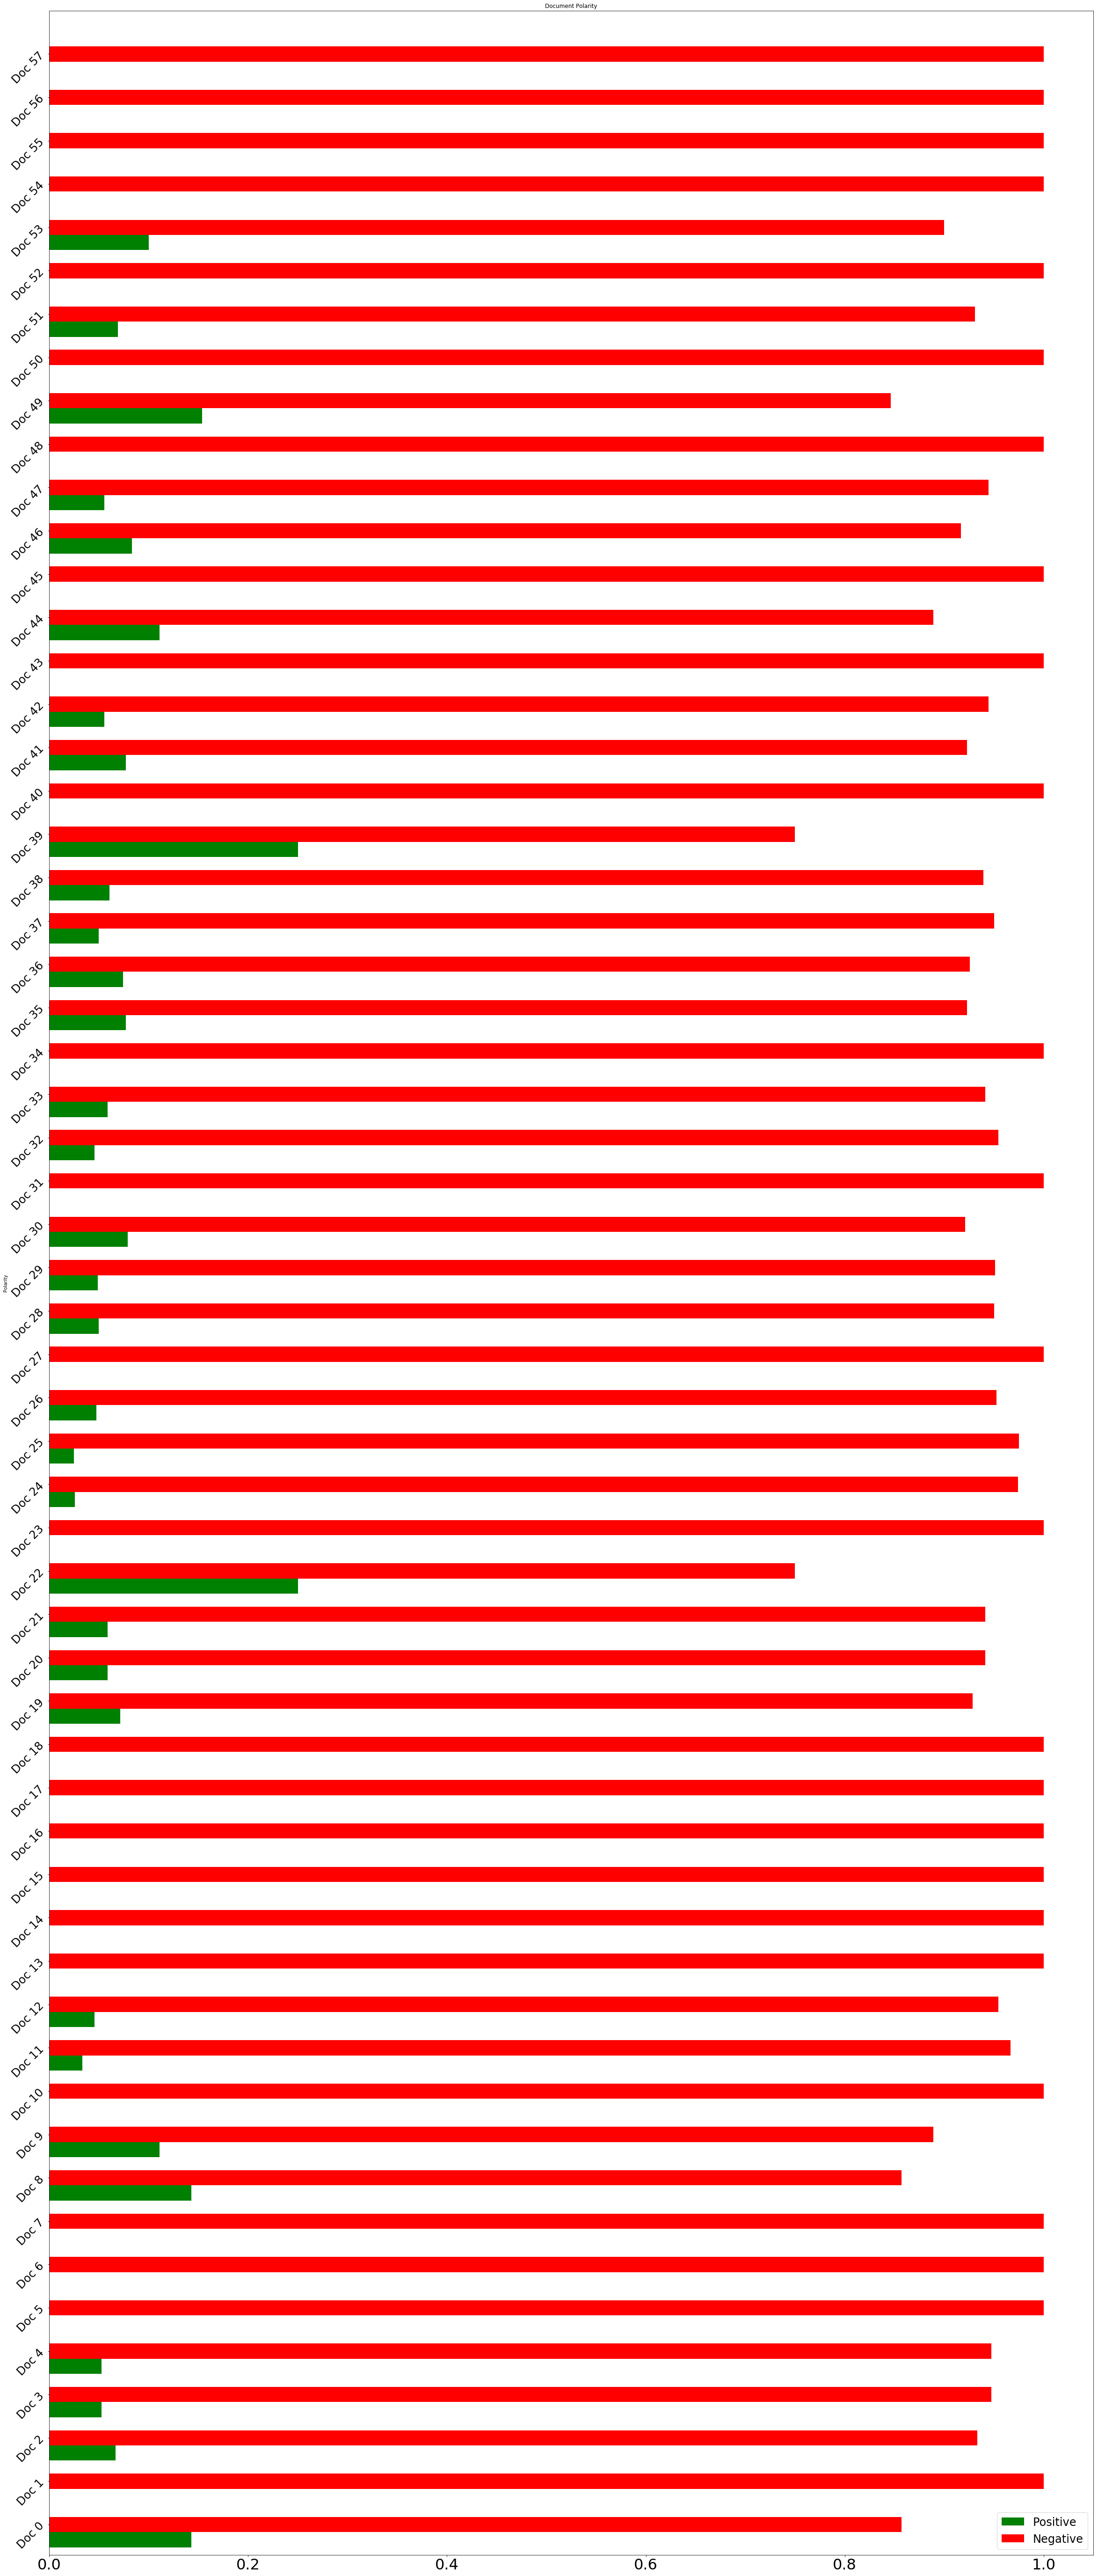

In [95]:
%matplotlib inline
fig = plt.figure(figsize=(40, 100))
ax = fig.add_subplot(111);
pos_values =[]
neg_values = []
for index_doc in result_sentiment:
    pos = result_sentiment[index_doc]['polarity'][0]/float(sum(result_sentiment[index_doc]['polarity']))
    pos_values.append(pos)      
    neg = result_sentiment[index_doc]['polarity'][1]/float(sum(result_sentiment[index_doc]['polarity']))
    neg_values.append(neg)


ind = np.arange(len(list(result_sentiment.keys())))                
width = 0.35                      # the width of the bars

## the bars
rects1 = ax.barh(ind, pos_values, width,
                color='green');

rects2 = ax.barh(ind+width, neg_values, width,
                    color='red');

# axes and labels
ax.set_ylim(-width,len(ind)+width);
#ax.set_xlim(0,45)
ax.set_ylabel('Polarity');
ax.set_title('Document Polarity');
yTickMarks = ['Doc %d'%(i) for i in list(result_sentiment.keys())];
ax.set_yticks(ind+width);
ytickNames = ax.set_yticklabels(yTickMarks);
plt.setp(ytickNames, rotation=45, fontsize=24);
plt.tick_params(axis='x', labelsize=32);
## add a legend
ax.legend( (rects1[0], rects2[0]), ('Positive', 'Negative') ,fontsize=24);

From the picture above, most of the documents in our data have a negative polarity.

I will print in HTML format the results

In [97]:

def add_html_text(s,color='red'):
    return '<text style=color:{}>{}</text>'.format(color,s)

def highlights_word(segment,l_word,l_new_word):
        assert len(l_word)==len(l_new_word), 'list should have the same length'
        for word,new_word in zip(l_word,l_new_word):
            segment=re.sub(word, new_word, segment, flags=re.IGNORECASE)
        return segment

    
def pretty_print_sentence(result):
    from IPython.display import display, HTML
    html_text='<table>'
    for index_doc,score_pos,score_neg,sentences in result:
        score_pos= score_pos/float(score_neg+score_pos)
        score_neg= score_neg/float(score_neg+score_pos)
        html_text=html_text+'<tr>'
        html_text=html_text+'<th>'+'</th>'
        html_text=html_text+'<th style=text-align:center;background-color:yellow>'+'Document number %s, with  %0.3f positive score  and  %0.3f negative score'%(index_doc,score_pos,score_neg)+'</th>'
        html_text=html_text+'</tr>'
        for num_sentence,(sentence,pos_word,neg_word) in enumerate(sentences):
            html_text=html_text+'<tr>'
            html_text=html_text+'<th style=white-space:nowrap>'+'Sentence %d'%(num_sentence)+'</th>'
            pos_word_html=[add_html_text(item.upper(),color='green') for item in pos_word]
            neg_word_html=[add_html_text(item.upper(),color='red') for item in neg_word]
            new_sentence_pos = highlights_word(sentence,pos_word,pos_word_html)
            new_sentence_neg = highlights_word(new_sentence_pos,neg_word,neg_word_html)
            new_sentence_html = add_html_text(new_sentence_neg.strip(),'blue')
            html_text=html_text+'<th style=text-align:left>'+new_sentence_html+'</th>'
            html_text=html_text+'</tr>'
    html_text=html_text+'</table>'
    display(HTML(html_text))

result_4_html = []
for index_file in result_sentiment:
    [file_polarity_pos,file_polarity_neg]= result_sentiment[index_file]['polarity'] 
    sentences = result_sentiment[index_file]['sentences']
    sent_4_html = []
    for index_sentence,sentence in enumerate(sentences):
        pos_words = result_sentiment[index_file]['pos_words'][index_sentence]
        neg_words = result_sentiment[index_file]['neg_words'][index_sentence]
        sent_4_html.append([sentence,pos_words,neg_words])
    result_4_html.append([index_file,file_polarity_pos,file_polarity_neg,sent_4_html])

pretty_print_sentence(result_4_html)

,"Document number 0, with 0.143 positive score and 0.992 negative score"
Sentence 0,By Byron Tau WASHINGTON -- The annual White House Correspondents' Association dinner went forward on Saturday without President Donald TRUMP the first president in more than 30 years to skip the gala.
Sentence 1,Mr. TRUMP opted to hold a rally in Pennsylvania to mark his hundredth day in office rather than attend the event in Washington which CELEBRATEs both the White House press corps and the presidency.
Sentence 2,The event also stars a professional comedian who uses the event to poke FUN at both the press and the administration.
Sentence 3,Instead of a monologue from Mr. TRUMP the event was headlined by veteran journalists Bob Woodward and Carl Bernstein along with comedian Hasan Minhaj.
Sentence 4,Messrs. Woodward and Bernstein are BEST known as the investigative reporting team that helped expose the Watergate SCANDAL that led to President Richard Nixon's RESIGNATION from office in 1974.
Sentence 5,In his remarks Mr. Minhaj riffed on Mr. TRUMP's ABSENCE.
Sentence 6,"""The leader of our country is not here -- and that's because he lives in Russia "" Mr. Minhaj said joking about ALLEGATIONs that Moscow INTERFEREd in the U.S. election."
Sentence 7,"Mr. TRUMP he continued ""tweets at 3 a.m. SOBER."
Sentence 8,Who is tweeting at 3 a.m. SOBER?
Sentence 9,Donald TRUMP because it's 10 a.m. in Russia.


* It is evident from the above results that still a contextual knowledge is missed in order to understand when a positive or negative word is an attitude and it does not refer to an entity.

* An interesting approach will be to train the sentiment analysis algorithms by associating a positive or negative score to each news according to the impact that that news had in the stock market.